In [1]:
import pandas as pd 
import numpy as np 
import scipy
# import xlrd 
import sklearn

from Gibbs_model_probit import Gibbs_sampling

from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from utils import baseline_lr,baseline_esnet,baseline_justmean
from utils import baseline_LogitElsnet,baseline_justmode,baseline_random,baseline_LogitLR,baseline_RanForest,baseline_Gibbs_zhe,baseline_SVM
from utils import baseline_LogitElsnet_leaveone,baseline_LogitLR_leaveone,baseline_SVM_leaveone

from sklearn.model_selection import KFold
from scipy.stats import binom 
from scipy.stats import norm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange
from Gibbd_zhe import GibbsSampling3
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
import time
from sklearn.preprocessing import StandardScaler

In [2]:
# data_loading 
np.random.seed(123)

# data_table = pd.read_csv('../data/processed/all_feature_p1_lip_total_single.csv')
data_table = pd.read_csv('../data/processed/all_feature_p1_lip_specie_single.csv')


target = '1= death; 0=alive'#'gap_surv_time_class' 'ADT_if_fail'


# normalization

# min-max
df = data_table[target]


# check nan
data_table[target].isnull().values.any()
# data_table.fillna(data_table.mean(), inplace=True) # fill nan with column mean

False

In [5]:
all_feature = data_table.iloc[:,1:-8]
all_feature

,lip_Cer(d16:1/16:0)_Cer_high_8,lip_Cer(d16:1/16:0)_Cer_low_8,lip_Cer(d16:1/18:0)_Cer_high_8,lip_Cer(d16:1/18:0)_Cer_low_8,lip_Cer(d16:1/20:0)_Cer_high_8,lip_Cer(d16:1/20:0)_Cer_low_8,lip_Cer(d16:1/22:0)_Cer_high_8,lip_Cer(d16:1/22:0)_Cer_low_8,lip_Cer(d16:1/23:0)_Cer_high_8,lip_Cer(d16:1/23:0)_Cer_low_8,...,lip_DG(18:1_22:5)_DG_low_30,lip_DG(18:0_22:6)_DG_high_30,lip_DG(18:0_22:6)_DG_low_30,lip_DG(18:1_22:6)_DG_high_30,lip_DG(18:1_22:6)_DG_low_30,lip_DG(18:2_22:6)_DG_high_30,lip_DG(18:2_22:6)_DG_low_30,AR_Amp,RB1_Del,TP53_SNP
0,0,1,0,1,0,1,0,1,0,1,...,1,1,0,0,1,0,1,0,0,1
1,1,0,0,1,0,1,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
2,0,1,1,0,1,0,0,1,0,1,...,1,1,0,0,1,0,1,0,0,0
3,0,1,0,1,0,1,0,1,0,1,...,1,1,0,0,1,0,1,0,0,0
4,0,1,0,1,0,1,0,1,0,1,...,0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,1,0,1,0,1,0,1,0,1,0,...,0,1,0,0,1,1,0,0,0,0
67,0,1,0,1,0,1,0,1,0,1,...,1,0,1,0,1,0,1,0,0,0
68,1,0,1,0,1,0,1,0,1,0,...,0,0,1,1,0,1,0,0,0,0
69,0,1,0,1,0,1,0,1,0,1,...,1,0,1,0,1,0,1,0,0,0


In [4]:
all_feature = data_table.iloc[:,1:-8]

lip_feature = all_feature.iloc[:,:12]#for p1 total
gene_feature = all_feature.iloc[:,12:]#for p1 total

# lip_feature = all_feature.iloc[:,:172]#for p1 specie
# gene_feature = all_feature.iloc[:,172:]#for p1 specie

Y = data_table[target].values
X = all_feature.values
# X = gene_feature.values
# X = lip_feature.values

print(X.shape)
# 141 = 41_lip + 100_total

(71, 175)


In [95]:
from sklearn.linear_model import LogisticRegression
target = '1= death; 0=alive'
# Y = data_table[target].values

X_train, X_test, y_train, y_test = train_test_split(
 X, Y, test_size=0.33, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test,y_test)

0.6666666666666666

In [98]:
# PCA analysis

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

lw = 2
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_r = pca.fit(X_new).transform(X_new)
# colors = ['navy',  'darkorange']
# target_names = ['dead','live']

# for color, i, target_name in zip(colors, [0, 1], target_names):
#     plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('PCA of p1_dead_or_live (with all lip and gene feature)')
# plt.show()
print(pca.singular_values_)
print(pca.explained_variance_ratio_.cumsum())
# singular_values_ of first 20 principle-components

[57.49950411 38.05363629 28.47576778 24.8465597  22.94776815]
[0.26762125 0.38483667 0.45047285 0.50044464 0.54307052]


In [37]:
X.shape

(71, 15)

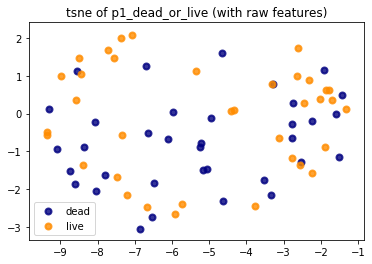

In [121]:
# visulize the x_r with t-sne, target：dead or live
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X_r)
# X_embedded = TSNE(n_components=2).fit_transform(X_new) # directlt on X

colors = ['navy',  'darkorange']
target_names = ['dead','live']
# X_embedded.shape
target = '1= death; 0=alive'# 'ADT_if_fail'
Y = data_table[target].values


for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_embedded[Y == i, 0], X_embedded[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_dead_or_live (with raw features)')
plt.show()

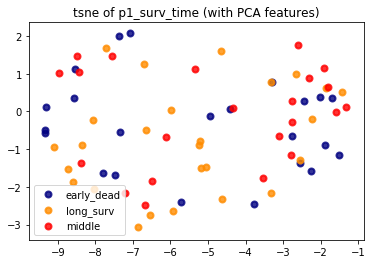

In [122]:
#  visulize the x_r with t-sne, target：surv_time
from sklearn.manifold import TSNE

target = 'gap_surv_time_class'# 'ADT_if_fail'
Y = data_table[target].values


# X_embedded = TSNE(n_components=2).fit_transform(X_r)
colors = ['navy',  'darkorange', 'red']
target_names = ['early_dead','long_surv','middle']
# X_embedded.shape

for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(X_embedded[Y == i, 0], X_embedded[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_surv_time (with PCA features)')
plt.show()

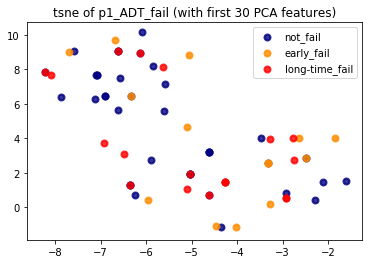

In [16]:
#  visulize the x_r with t-sne, target：ADT_fail
# from sklearn.manifold import TSNE

# target = 'ADT_start_fail'
# Y = data_table[target].values
# Y_new = np.zeros(len(Y)) 
# Y_new[np.argwhere(Y>=0)]=1
# Y_new[np.argwhere(Y>365)]=2


# # X_embedded = TSNE(n_components=2).fit_transform(X_r)
# colors = ['navy',  'darkorange', 'red']
# target_names = ['not_fail','early_fail','long-time_fail']
# # X_embedded.shape

# for color, i, target_name in zip(colors, [0.0, 1,2], target_names):
#     plt.scatter(X_embedded[Y_new == i, 0], X_embedded[Y_new == i, 1], color=color, alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('tsne of p1_ADT_fail (with first 30 PCA features)')
# plt.show()

In [144]:
# leave-one test on raw feature
# target = '1= death; 0=alive'
# target = 'gap_surv_time_class'
Y = data_table[target].values


loo = LeaveOneOut()
# X = X_r
N = loo.get_n_splits(X)

lr_acc = np.zeros(N)
esnet_acc = np.zeros(N)
mode_acc = np.zeros(N)
random_acc = np.zeros(N)
svm_acc = np.zeros(N)




for i,index in enumerate(loo.split(X)):
    train_index, test_index = index
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    data_dict = {'X_tr':X_train, 'y_tr':y_train, 'X_test':X_test, 'y_test':y_test}
    dict_lr = baseline_LogitLR_leaveone(data_dict)
    dict_els = baseline_LogitElsnet_leaveone(data_dict)
    # dict_rf = baseline_RanForest(data_dict)
    dict_mode = baseline_justmode(data_dict)
    dict_random = baseline_random(data_dict)
    dict_svm = baseline_SVM_leaveone(data_dict)

    lr_acc[i] = dict_lr['acr']
    esnet_acc[i] = dict_els['acr']

    mode_acc[i] = dict_mode['acr']
    random_acc[i] = dict_random['acr']
    svm_acc[i] = dict_svm['acr']

print('lr_acr_mean: %.4f,lr_acr_std: %.4f '%(lr_acc.mean(),lr_acc.std() ) )
print('esnet_acr_mean: %.4f,esnet_acr_std: %.4f '%(esnet_acc.mean(),esnet_acc.std() ) )
print('svm_acr_mean: %.4f,rf_acr_mean: %.4f '%(svm_acc.mean(),svm_acc.std() ) )
print('just-mode_acr_mean: %.4f,mode_acr_std: %.4f '%(mode_acc.mean(),mode_acc.std() ) )
print('just-random_acr_mean: %.4f,just-random_acr_std: %.4f '%(random_acc.mean(),random_acc.std() ) )

G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

lr_acr_mean: 0.7324,lr_acr_std: 0.4427 
esnet_acr_mean: 0.7324,esnet_acr_std: 0.4427 
svm_acr_mean: 0.6479,rf_acr_mean: 0.4776 
just-mode_acr_mean: 0.0000,mode_acr_std: 0.0000 
just-random_acr_mean: 0.5070,just-random_acr_std: 0.5000 


G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
G:\anaconda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

In [126]:
# leave-one test on PCA features
target = '1= death; 0=alive'
Y = data_table[target].values


loo = LeaveOneOut()
X = X_r
N = loo.get_n_splits(X)

lr_acc = np.zeros(N)
esnet_acc = np.zeros(N)
mode_acc = np.zeros(N)
random_acc = np.zeros(N)
svm_acc = np.zeros(N)




for i,index in enumerate(loo.split(X)):
    train_index, test_index = index
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    data_dict = {'X_tr':X_train, 'y_tr':y_train, 'X_test':X_test, 'y_test':y_test}
    dict_lr = baseline_LogitLR_leaveone(data_dict)
    dict_els = baseline_LogitElsnet_leaveone(data_dict)
    # dict_rf = baseline_RanForest(data_dict)
    dict_mode = baseline_justmode(data_dict)
    dict_random = baseline_random(data_dict)
    dict_svm = baseline_SVM_leaveone(data_dict)

    lr_acc[i] = dict_lr['acr']
    esnet_acc[i] = dict_els['acr']

    mode_acc[i] = dict_mode['acr']
    random_acc[i] = dict_random['acr']
    svm_acc[i] = dict_svm['acr']

print('lr_acr_mean: %.4f,lr_acr_std: %.4f '%(lr_acc.mean(),lr_acc.std() ) )
print('esnet_acr_mean: %.4f,esnet_acr_std: %.4f '%(esnet_acc.mean(),esnet_acc.std() ) )
print('svm_acr_mean: %.4f,rf_acr_mean: %.4f '%(svm_acc.mean(),svm_acc.std() ) )
print('just-mode_acr_mean: %.4f,mode_acr_std: %.4f '%(mode_acc.mean(),mode_acc.std() ) )
print('just-random_acr_mean: %.4f,just-random_acr_std: %.4f '%(random_acc.mean(),random_acc.std() ) )

lr_acr_mean: 0.5634,lr_acr_std: 0.4960 
esnet_acr_mean: 0.5634,esnet_acr_std: 0.4960 
svm_acr_mean: 0.4507,rf_acr_mean: 0.4976 
just-mode_acr_mean: 0.0000,mode_acr_std: 0.0000 
just-random_acr_mean: 0.4648,just-random_acr_std: 0.4988 


In [14]:
X.shape

(71, 10)